In [1]:
import config as cfg
from dataprocessing import PKUSingleObjectTestDataset
import dataprocessing as D
import os
import json

In [2]:
test_ds = D.PKUSingleObjectTestDataset(
    json_image_info=cfg.TEST_IMAGE_INFO_JSON,
    json_detections=cfg.TEST_DETECTIONS,
    json_annotations=os.path.join(cfg.CV_DIR, 'fold-1', 'train_objects_both_train.json'),
    images_dir=cfg.TEST_IMAGES,
    masks_dir=cfg.TEST_IGNORE_MASKS,
    prepare_sample_fn=D.prepare_test_sample_fn_v1
)

Loading image info from /datasets/pku-autonomous-driving/annotations/json/test_image_info.json
Loading detections from /home/ivb/Repos/cds-mmdetection/work_dirs/pku-autonomous-driving/cascade_rcnn_hrnetv2p_w48_v2/test_ms_flip_reindexed.bbox.json
Loading annotations from /datasets/pku-autonomous-driving/annotations/json/cv/fold-1/train_objects_both_train.json
Number of labels: 34
{3: 0, 7: 1, 8: 2, 9: 3, 10: 4, 13: 5, 15: 6, 17: 7, 19: 8, 20: 9, 21: 10, 24: 11, 26: 12, 28: 13, 29: 14, 32: 15, 33: 16, 36: 17, 38: 18, 41: 19, 44: 20, 47: 21, 48: 22, 49: 23, 51: 24, 52: 25, 55: 26, 57: 27, 61: 28, 62: 29, 67: 30, 71: 31, 72: 32, 77: 33}
Loading images


100%|██████████| 2021/2021 [00:01<00:00, 1219.41it/s]


In [12]:
with open('/datasets/pku-autonomous-driving/cv_old/fold-1/train_objects_both_single_class_with_ignore_valid.json', 'r') as f:
    cv_old = json.load(f)

In [15]:
with open('/datasets/pku-autonomous-driving/annotations/json/cv/fold-1/train_objects_both_single_class_valid.json', 'r') as f:
    cv_new = json.load(f)

In [16]:
len(cv_old['images']), len(cv_old['images'])

(853, 853)

In [20]:
old = [img['file_name'] for img in cv_old['images']]

In [21]:
new = [img['file_name'] for img in cv_new['images']]

In [23]:
len(set(old).intersection(new))

162

In [3]:
r = test_ds[2]

In [4]:
r.keys()

dict_keys(['idx', 'image_id', 'image', 'bbox', 'score'])

In [5]:
r['image_id'], r['score']

(0, 0.9988736510276794)

In [6]:
import matplotlib.pyplot as plt
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


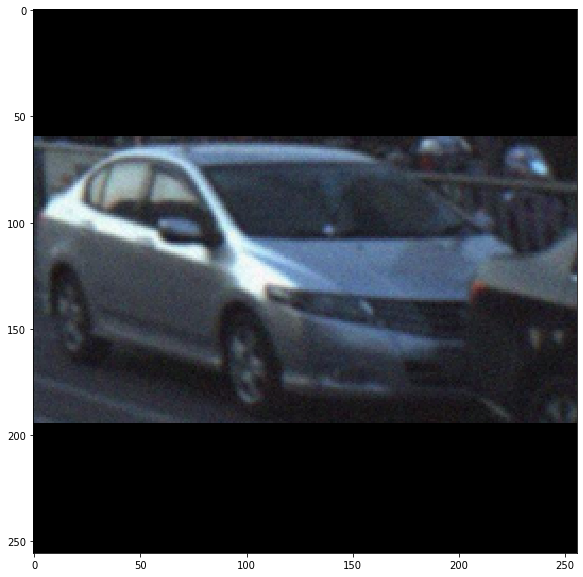

In [7]:
plt.figure(figsize=[15, 10])
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

In [2]:
ds = PKUJsonDataset(cfg.TRAIN_OBJECTS_BOTH_JSON, cfg.TRAIN_IMAGES)

100%|██████████| 4219/4219 [00:02<00:00, 1969.11it/s]


In [3]:
# w/o SIMD
%%timeit
ds.decode_image(ds.images_jpeg[0])

103 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
%%timeit
ds.decode_image(ds.images_jpeg[0])

47.6 ms ± 8.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [6]:
from PIL import features, Image
from packaging import version

if version.parse(Image.PILLOW_VERSION) >= version.parse("5.4.0"):
    if features.check_feature('libjpeg_turbo'):
        print("libjpeg-turbo is on")
    else:
        print("libjpeg-turbo is not on")
else:
    print(f"libjpeg-turbo' status can't be derived - need Pillow(-SIMD)? >= 5.4.0 to tell, current version {Image.PILLOW_VERSION}")

libjpeg-turbo is on


In [9]:
import torch
import numpy as np
import json
import config as C
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import parse_camera_intrinsic as parse_camera_intrinsic
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms as T
from torch import nn
from tqdm import tqdm

In [10]:
p = parse_camera_intrinsic()
for k in p:
    p[k] = torch.from_numpy(np.array(p[k],dtype=np.float))

In [15]:
import io
class PKURegressionDataset(Dataset):
    
    def __init__(self, orientation_field, images_dir, max_size, transforms=None):
        super().__init__()
        self.orientation_field = orientation_field
        self.images_dir = images_dir
        self.max_size = max_size
        self.transforms = transforms
        
        with open(C.TRAIN_CROPS_JSON, "r") as f:
            self.gt = json.load(f)
        
        cat_ids = set(ann['category_id'] for ann in self.gt['annotations'])
        categories = [cat for cat in self.gt['categories'] if cat['id'] in cat_ids]
        self.category_id_to_label = {
            cat["id"]: label
            for label, cat in enumerate(sorted(categories, key=lambda x: x["id"]))
        }
        self.images_jpeg = self.load_images()
        
        self.p = parse_camera_intrinsic()
        for k in self.p:
            self.p[k] = float(self.p[k])
    
    def load_images(self):
        images = {}
        for image in tqdm(self.gt['images']):
            path = os.path.join(self.images_dir, image['file_name'])
            data = open(path, 'rb').read()
            images[image['id']] = io.BytesIO(data)
        return images
    
    def __len__(self):
        return len(self.gt["annotations"])
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.get_label(idx)
        bbox_x, bbox_y, bbox_w, bbox_h = self.get_bbox(idx)
        bbox_center_x, bbox_center_y = bbox_x + bbox_w / 2, bbox_y + bbox_h / 2
        wx, wy, wz = self.get_position(idx)
        orientation = self.get_orientation(idx)
        
        result =  dict(
            image=image,
            label=label,
            bbox=np.array([(bbox_center_x-self.p['cx'])/self.p['fx'], (bbox_center_y-self.p['cy'])/self.p['fy'], bbox_w/self.p['fx'], bbox_h/self.p['fy']]),
            position=np.array([wx, wy, wz]),
            distance=np.sqrt(wx**2 + wy**2 + wz**2),
            orientation=np.array(orientation)
        )
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
        return result
    
    def load_image(self, idx):
        image_id = self.gt["annotations"][idx]["image_id"]
        image = self.decode_image(self.images_jpeg[image_id])
        w, h = image.size
        scale = self.max_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_size, self.max_size))
        new_image.paste(image, ((self.max_size - w_new) // 2, (self.max_size - h_new) // 2))
        return new_image
        
    @staticmethod
    def decode_image(bytes_io):
        image = Image.open(bytes_io)
        image.load()
        return image
        
    def get_label(self, idx):
        return self.category_id_to_label[self.gt["annotations"][idx]["category_id"]]
    
    def get_bbox(self, idx):
        return self.gt["annotations"][idx]["bbox"]
    
    def get_position(self, idx):
        return self.gt["annotations"][idx]["position"]
    
    def get_orientation(self, idx):
        euler_angles = self.gt["annotations"][idx][self.orientation_field]
        rotation = R.from_euler("YXZ", euler_angles)
        q = rotation.as_quat()
        e = np.array([0,0,1])
        q[:3] = q[:3] * np.dot(e, q[:3]) / (np.abs(np.dot(q[:3], e)))
        return q

In [12]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [16]:
ds = PKURegressionDataset("orientation", C.TRAIN_CROPS_ORIGIN, 256, transforms)

100%|██████████| 49115/49115 [00:01<00:00, 30429.58it/s]


In [17]:
r = ds[3]

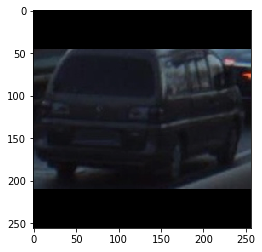

In [18]:
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))